In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
stock = yf.download('TSLA', "2010-01-01", "2024-01-01")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
stock.columns

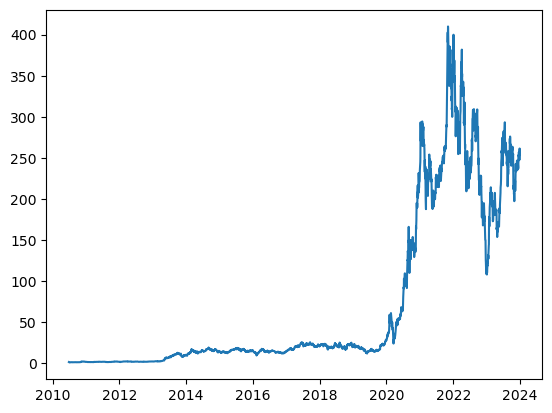

In [3]:
plt.plot(stock['Close'])

In [ ]:
stock['Close']

In [4]:
stock['Close'].ffill(inplace=True)
day_rets = [np.divide(stock['Close'][i], stock['Open'][i]) - 1 for i in range(len(stock['Close']))]

C:\Users\coeno\AppData\Local\Temp\ipykernel_12040\2666579349.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day_rets = [np.divide(stock['Close'][i], stock['Open'][i]) - 1 for i in range(len(stock['Close']))]


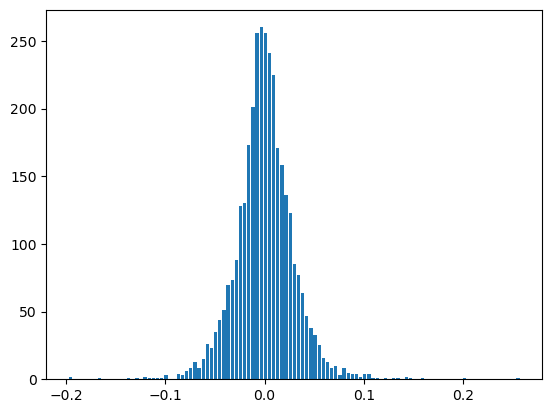

In [8]:
%matplotlib inline
_ = plt.hist(day_rets, bins='auto',rwidth=0.8)

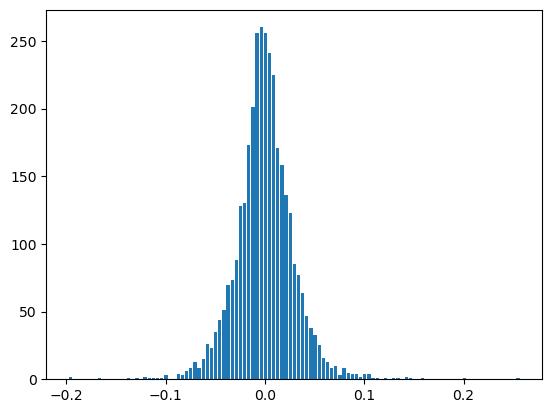

In [5]:
demean = day_rets - np.mean(day_rets)
_ = plt.hist(demean, bins='auto',rwidth=0.8)

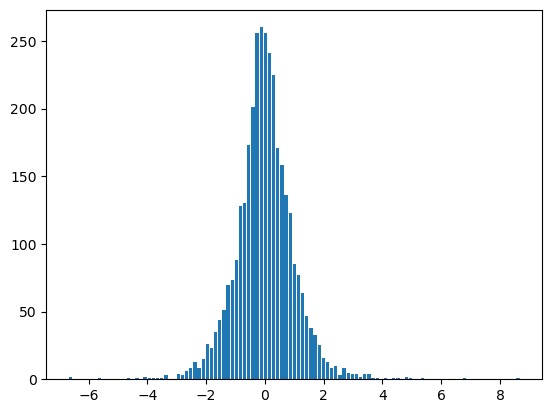

In [6]:
devar = np.divide(demean, np.std(demean))
_ = plt.hist(devar, bins='auto',rwidth=0.8)

In [9]:
ret_batches = []
batch_size = 25

ret_batches.append(devar[:batch_size])
ret_batches.pop

for i in range(batch_size, len(devar)):
    ret_batches.append(np.concatenate([ret_batches[-1][1:], [devar[i]]]))

ret_batches = np.array(ret_batches)

In [10]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib qt

x = np.arange(0, len(ret_batches[0]))
y = np.arange(0, len(ret_batches[:100]))

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(Y, X, ret_batches[:100])
plt.show()

In [11]:
prod_batches = []
duration = 5

for i in range(batch_size, len(day_rets) - duration + 1):
    prod_batches.append(np.subtract(np.cumprod(np.add(day_rets[i:i+duration], 1)), 1))

In [12]:
goal = 0.025
hit = []

for batch in prod_batches:
    hit.append(True in (batch >= goal))

hit.count(True)/len(hit)

0.5022248590922574

In [13]:
current = ret_batches[-duration:]
history = ret_batches[:-duration]

In [14]:
df = pd.DataFrame(history)
df.insert(25, 'Hit', hit)

In [15]:
concat = df.to_numpy()

In [27]:
shuffled = np.random.permutation(concat)

In [28]:
train = int((0.6*len(shuffled))//1)
seen = int((0.3*len(shuffled))//1)
unseen = int((0.1*len(shuffled))//1)

train_data = shuffled[0:train]
seen_data = shuffled[train:train+seen]
unseen_data = shuffled[train+seen:]

In [29]:
pop_size = 1000

rand_rows = []

options = list(np.arange(0, train))

for i in range(pop_size):
    item = np.random.randint(0, len(options))
    rand_rows.append(options[item])
    options.pop(item)

In [30]:
individuals = []

for i in range(pop_size):
    feature_set = []
    base_features = train_data[rand_rows[i]]
    rand = np.random.random() * 2

    for j in range(batch_size):
        roll = np.random.uniform()
        low = -10
        high = 10

        if roll > 0.6:
            low = base_features[j] - rand
            high = base_features[j] + rand
        feature_set.append([low, high])
    
    individuals.append(feature_set)

In [31]:
guesses = []
successes = []

for ind in individuals:
    breakdown = dict(cor_true=0, cor_false=0, inc_true=0, inc_false=0)
    correct = 0

    for batch in train_data:
        guess = True

        for feature, obs in zip(ind, batch[:-1]):
            if obs < feature[0] or obs > feature[1]:
                guess = False
                break
        
        if guess == batch[-1]:
            if guess:
                breakdown['cor_true'] += 1
                correct += 1
            else:
                breakdown['cor_false'] += 1
        else:
            if guess:
                breakdown['inc_true'] += 1
            else:
                breakdown['inc_false'] += 1
    
    guesses.append(breakdown)
    successes.append(correct)

In [28]:
np.divide(successes,train)

array([0.10830861, 0.00197824, 0.        , 0.08160237, 0.00049456,
       0.00049456, 0.00395648, 0.00098912, 0.04451039, 0.11424332,
       0.07962413, 0.        , 0.00049456, 0.00049456, 0.01384768,
       0.19930762, 0.00098912, 0.00098912, 0.00049456, 0.        ,
       0.2388724 , 0.        , 0.        , 0.05440158, 0.00049456,
       0.        , 0.00939664, 0.        , 0.        , 0.00098912,
       0.        , 0.09000989, 0.00890208, 0.08259149, 0.00197824,
       0.00395648, 0.00148368, 0.00049456, 0.01186944, 0.14836795,
       0.00049456, 0.00049456, 0.        , 0.        , 0.        ,
       0.00049456, 0.00642928, 0.00049456, 0.00049456, 0.00346192,
       0.0024728 , 0.00049456, 0.01533136, 0.01978239, 0.        ,
       0.00890208, 0.        , 0.10187933, 0.01186944, 0.00049456,
       0.00148368, 0.00296736, 0.00049456, 0.        , 0.        ,
       0.00049456, 0.00049456, 0.25816024, 0.00049456, 0.        ,
       0.00049456, 0.00049456, 0.00593472, 0.00049456, 0.18743

In [29]:
guesses[successes.index(max(successes))]

{'cor_true': 663, 'cor_false': 327, 'inc_true': 680, 'inc_false': 352}

In [ ]:
list(train_data[:, -1]).count(False)

In [32]:
def fitness(cor_t, cor_f, inc_t, inc_f):
    return (cor_t + cor_f - inc_f - inc_t)*(cor_t/(cor_t + inc_f))*(cor_f/(cor_f + inc_t))

In [33]:
how_fit = []

for bd in guesses:
    how_fit.append(
        fitness(
            bd['cor_true'],
            bd['cor_false'],
            bd['inc_true'],
            bd['inc_false']
        )
    )

max(how_fit)

10.605246783131397

In [34]:
from heapq import nlargest

fittest = [individuals[how_fit.index(n)] for n in nlargest(2, how_fit)]
# fittest = [individuals[successes.index(n)] for n in nlargest(2, successes)]

In [ ]:
nlargest(2, how_fit)

In [ ]:
individuals[how_fit.index(nlargest(2, how_fit)[0])]

In [ ]:
fittest[0] == fittest[1]

In [ ]:
fittest[0]

In [35]:
from copy import deepcopy

In [36]:
for asdf in range(10000):
    new_pop = [deepcopy(fittest[0])]

    while len(new_pop) < 1000:
        rand = np.random.randint(0, 24)
    
        child_1 = fittest[0][:rand].copy() + fittest[1][rand:]
        child_1 = deepcopy(child_1)
        mutate = np.random.random()
        if mutate < 0.01:
            mutation = np.random.randint(0, 5)
            gene = np.random.randint(0, 25)

            if mutation == 0:
                if child_1[gene][0] > 0:
                    child_1[gene][0] *= 0.75
                else:
                    child_1[gene][0] *= 1.25
                if child_1[gene][1] > 0:
                    child_1[gene][1] *= 1.25
                else:
                    child_1[gene][1] *= 0.75
            elif mutation == 1:
                if child_1[gene][0] < 0:
                    child_1[gene][0] *= 0.75
                else:
                    child_1[gene][0] *= 1.25
                if child_1[gene][1] < 0:
                    child_1[gene][1] *= 1.25
                else:
                    child_1[gene][1] *= 0.75
            elif mutation == 2:
                child_1[gene][0] += 1
                child_1[gene][1] += 1
            elif mutation == 3:
                child_1[gene][0] -= 1
                child_1[gene][1] -= 1
            elif mutation == 4:
                child_1[gene][0] = -10
                child_1[gene][1] = 10

        child_2 = fittest[1][:rand] + fittest[0][rand:]
        child_2 = deepcopy(child_2)

        mutate = np.random.random()
        if mutate < 0.01:
            mutation = np.random.randint(0, 5)
            gene = np.random.randint(0, 25)

            if mutation == 0:
                child_2[gene][0] *= 1.25
                child_2[gene][1] *= 1.25
            elif mutation == 1:
                child_2[gene][0] *= 0.75
                child_2[gene][1] *= 0.75
            elif mutation == 2:
                child_2[gene][0] += 1
                child_2[gene][1] += 1
            elif mutation == 3:
                child_2[gene][0] -= 1
                child_2[gene][1] -= 1
            elif mutation == 4:
                child_2[gene][0] = -10
                child_2[gene][1] = 10

        new_pop.append(child_1)
        new_pop.append(child_2)

    guesses = []
    successes = []

    for ind in new_pop:
        breakdown = dict(cor_true=0, cor_false=0, inc_true=0, inc_false=0)
        correct = 0

        for batch in train_data:
            guess = True

            for feature, obs in zip(ind, batch[:-1]):
                if obs < feature[0] or obs > feature[1]:
                    guess = False
                    break
        
            if guess == batch[-1]:
                if guess:
                    breakdown['cor_true'] += 1
                    correct += 1
                else:
                    breakdown['cor_false'] += 1
            else:
                if guess:
                    breakdown['inc_true'] += 1
                else:
                    breakdown['inc_false'] += 1
    
        guesses.append(breakdown)
        successes.append(correct)

    how_fit = []

    for bd in guesses:
        try:
            how_fit.append(
            fitness(
                bd['cor_true'],
                bd['cor_false'],
                bd['inc_true'],
                bd['inc_false']
                )
            )
        except ZeroDivisionError:
            pass

    fittest = [new_pop[how_fit.index(n)] for n in nlargest(2, how_fit)]

    if fittest[0] == fittest[1]:
        feature_set = []
        base_features = train_data[rand_rows[i]]
        rand = np.random.random() * 2

        for j in range(batch_size):
            roll = np.random.uniform()
            low = -10
            high = 10

            if roll > 0.4:
                low = base_features[j] - rand
                high = base_features[j] + rand
            feature_set.append([low, high])
    
        fittest[1] = feature_set

    print(max(successes))
    print(guesses[successes.index(max(successes))])
    print(guesses[how_fit.index(max(how_fit))])
    print(max(how_fit))
    print(asdf)

496
{'cor_true': 496, 'cor_false': 515, 'inc_true': 499, 'inc_false': 512}
{'cor_true': 291, 'cor_false': 745, 'inc_true': 269, 'inc_false': 717}
10.605246783131397
0
510
{'cor_true': 510, 'cor_false': 458, 'inc_true': 556, 'inc_false': 498}
{'cor_true': 291, 'cor_false': 745, 'inc_true': 269, 'inc_false': 717}
10.605246783131397
1
291
{'cor_true': 291, 'cor_false': 745, 'inc_true': 269, 'inc_false': 717}
{'cor_true': 291, 'cor_false': 745, 'inc_true': 269, 'inc_false': 717}
10.605246783131397
2
511
{'cor_true': 511, 'cor_false': 470, 'inc_true': 544, 'inc_false': 497}
{'cor_true': 291, 'cor_false': 745, 'inc_true': 269, 'inc_false': 717}
10.605246783131397
3
291
{'cor_true': 291, 'cor_false': 745, 'inc_true': 269, 'inc_false': 717}
{'cor_true': 291, 'cor_false': 745, 'inc_true': 269, 'inc_false': 717}
10.605246783131397
4
374
{'cor_true': 374, 'cor_false': 595, 'inc_true': 419, 'inc_false': 634}
{'cor_true': 291, 'cor_false': 745, 'inc_true': 269, 'inc_false': 717}
10.605246783131397


KeyboardInterrupt: 

In [37]:
guesses = []
successes = []

for ind in new_pop:
    breakdown = dict(cor_true=0, cor_false=0, inc_true=0, inc_false=0)
    correct = 0

    for batch in seen_data:
        guess = True

        for feature, obs in zip(ind, batch[:-1]):
            if obs < feature[0] or obs > feature[1]:
                guess = False
                break
        
        if guess == batch[-1]:
            if guess:
                breakdown['cor_true'] += 1
                correct += 1
            else:
                breakdown['cor_false'] += 1
        else:
            if guess:
                breakdown['inc_true'] += 1
            else:
                breakdown['inc_false'] += 1
    
    guesses.append(breakdown)
    successes.append(correct)

In [38]:
guesses[successes.index(max(successes))]

{'cor_true': 199, 'cor_false': 281, 'inc_true': 227, 'inc_false': 304}

In [39]:
guesses[successes.index(max(successes))]['cor_true']/(list(seen_data[:, -1]).count(True))

0.3956262425447316